## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

features:

    - frequency domain:
        - peaks of ppg (in decreasing power order). e.g. first 10 peaks in interval 40-240BPM
        - peaks of accx
        - peaks of accy
        - peaks of accz
        - peaks of acc total (summed frequencys: accx+accy+accz)
        - peaks of acc total (calculated in time domain and then fft)
        - fraction of spectral energy in each 1Hz from 1 to 4 Hz of ppg signal
        - fraction of spectral energy in each 1Hz from 1 to 4 Hz of total acc signal
        
    - time domain:
        - mean of ppg signal (evtl. acc signals)
        - std of ppg signal (evtl. acc signals)
        - evtl. correlations between accx and ppg signal
        - evtl. correlations between accy and ppg signal
        - evtl. correlations between accz and ppg signal
        - evtl. correlations between acc and ppg signal


### Code

In [1]:
import glob
import sys
import numpy as np
import scipy as sp
import scipy.signal
import scipy.io
import sklearn
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

print(f'Python version: {sys.version}')
print(f'Numpy version: {np.__version__}')
print(f'Scipy version: {sp.__version__}')
print(f'sklearn version: {sklearn.__version__}')

Python version: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
Numpy version: 1.19.1
Scipy version: 1.5.2
sklearn version: 0.23.2


In [2]:
def LoadTroikaDataset():
    """
    Get filenames in considered data directory.
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data (labels)
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls


def load_troika_data(data_fl):
    """
    Load complete data file with all signals
    :return: dictionary with keys '__header__', '__version__', '__globals__', 'sig'.
        Most important is the signal key 'sig'.
        The sig key contains a matrix with 6 rows:
            row 1: ECG signal (can be used to calculate the reference heart rate signal -> already done, see REF_... files)
            row 2: 1st PPG channel
            row 3: 2nd PPG channel
            row 4: x-axis of acceleration data
            row 5: y-axis of acceleration data
            row 6: z-axis of acceleration data
    """
    return sp.io.loadmat(data_fl)


def LoadTroikaDataFile(data_fl):
    """
    Load data.
    Loads and extracts signals from a troika data file.
    We are only insterested in these signals: one PPG channel (we use the 2nd), the three acceleration data channels.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = load_troika_data(data_fl)['sig']
    return data[2:]


def load_labels(ref_fl):
    """
    load reference signal (label)
    The reference signal contains the ground-truth of heart rate in beats per minute (BPM)
    in an 8 second window. Two consecutive windows are shifted by 2 seconds. This means
    that consecutive windows are overlapping by 6 seconds. First window covers the first 8
    seconds, second window covers 3rd second to 10th second, ...    
    """
    return sp.io.loadmat(ref_fl)['BPM0'].flatten()


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates in BPM.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))


def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    
    """
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)

    # Compute pulse rate estimates and estimation confidence.

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    # How much energy in the frequency spectrum is concentrated near the pulse rate estimate? 
    # You can answer this by summing the frequency spectrum near the pulse rate estimate and dividing it by the sum of the entire spectrum.
    errors, confidence = np.ones(100), np.ones(100)  # Dummy placeholders. Remove
    return errors, confidence

In [3]:
Evaluate()

1.0

In [4]:
def plot_raw_signals(ppg, accx, accy, accz):
    """
    Plot all raw signals that belong together
    :param ppg: PPG signal
    :param accx: Accelerometer signal in x-direction
    :param accy: accelerometer signal in y-direction
    :param accz: accelerometer signal in z-direction
    :return: figure with all signals
    """
    ts = np.arange(0, len(ppg), 1) / FS
    fig, axarr = plt.subplots(4, figsize=(15, 15))
    axarr[0].plot(ts, ppg)
    axarr[0].set_xlabel('time (sec)')
    axarr[0].set_ylabel('amplitude')
    axarr[0].set_title('PPG signal')
    axarr[1].plot(ts, accx)
    axarr[1].set_xlabel('time (sec)')
    axarr[1].set_ylabel('amplitude (mV)')
    axarr[1].set_title('Acceleration x-axis signal')
    axarr[2].plot(ts, accy)
    axarr[2].set_xlabel('time (sec)')
    axarr[2].set_ylabel('amplitude (mV)')
    axarr[2].set_title('Acceleration y-axis signal')
    axarr[3].plot(ts, accz)
    axarr[3].set_xlabel('time (sec)')
    axarr[3].set_ylabel('amplitude (mV)')
    axarr[3].set_title('Acceleration z-axis signal')
    plt.tight_layout()
    return fig


def plot_spectogram(ppg, accx, accy, accz, fs, window_length, window_shift, min_freq, max_freq):
    """
    plot sectrograms of all PPG and accelerometer signals
    :param ppg: PPG signal
    :param accx: Accelerometer signal in x-direction
    :param accy: accelerometer signal in y-direction
    :param accz: accelerometer signal in z-direction
    :param fs: sample frequency
    :param window_length: length of the window/filter (in sample units)
    :param window_shift: shift of window for each step/ stride (in sample units)
    :param min_freq: minimum frequency (y-axis) to plot
    :param max_freq: maximum frequency (y-axis) to plot
    :return: sectrogram figure object
    """
    # timestamps in minutes
    fig, axarr = plt.subplots(4, figsize=(15, 20))
    # we are splitting data x into NFFT length segments (local/smaller time segments) and compute the spectrum 
    # (fourier transform) of each section.
    # freq contains the frequencies containing to the rows (y-axis ^= frequencies) in the spectrum
    # Fs: sample frequency
    # NFFT: number of data points in each segment -> we will have ca. len(x)/NFFT segments 
    # (=time segments = rows in spec matrix). 
    # This is only approximately because we most likely divide the signel by a number that is an exact divisor of len(x)
    # here: we have a sample frequency of fs Hz and calculate FFT in intervals of length NFFT=fs*10 (= 10 sec).
    ppg_spec, ppg_spec_freqs, ppg_t, ppg_img = axarr[0].specgram(
        x=ppg_filtered, NFFT=window_length, Fs=fs,
        noverlap=window_length-window_shift, cmap='jet_r'
    )
    axarr[0].set_xlabel('time (sec)')
    axarr[0].set_ylabel('frequency (Hz)')
    axarr[0].set_title('Spectogram of PPG signal')
    divider = make_axes_locatable(axarr[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(ppg_img, cax=cax, orientation='vertical')
    ppg_img.set_clim(0, 50)
    axarr[0].set_ylim((min_freq, max_freq))

    accx_spec, accx_spec_freqs, accx_t, accx_img = axarr[1].specgram(
        x=accx_filtered, NFFT=window_length, Fs=fs,
        noverlap=window_length-window_shift, cmap='jet_r'
    )
    axarr[1].set_xlabel('time (sec)')
    axarr[1].set_ylabel('frequency (Hz)')
    axarr[1].set_title('Spectogram of acceleration signal in x-direction')
    divider = make_axes_locatable(axarr[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(accx_img, cax=cax, orientation='vertical')
    accx_img.set_clim(-50, 0)
    axarr[1].set_ylim((min_freq, max_freq))

    accy_spec, accy_spec_freqs, accy_t, accy_img = axarr[2].specgram(
        x=accy_filtered, NFFT=window_length, Fs=fs,
        noverlap=window_length-window_shift, cmap='jet_r'
    )
    axarr[2].set_xlabel('time (sec)')
    axarr[2].set_ylabel('frequency (Hz)')
    axarr[2].set_title('Spectogram of acceleration signal in y-direction')
    divider = make_axes_locatable(axarr[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(accy_img, cax=cax, orientation='vertical')
    accy_img.set_clim(-50, 0)
    axarr[2].set_ylim((min_freq, max_freq))

    accz_spec, accz_spec_freqs, accz_t, accz_img = axarr[3].specgram(
        x=accz_filtered, NFFT=window_length, Fs=fs,
        noverlap=window_length-window_shift, cmap='jet_r'
    )
    axarr[3].set_xlabel('time (sec)')
    axarr[3].set_ylabel('frequency (Hz)')
    axarr[3].set_title('Spectogram of acceleration signal in z-direction')
    divider = make_axes_locatable(axarr[3])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(accz_img, cax=cax, orientation='vertical')
    accz_img.set_clim(-50, 0)
    axarr[3].set_ylim((min_freq, max_freq))
    plt.tight_layout()
    return fig


def plot_window_prediction (freqs, ppg_fft, ppg_peaks, ppg_label,
                            acc_fft, accx_fft, accy_fft, accz_fft, acc_peaks,
                            min_freq, max_freq):
    """
    Plot a window of the complete signal which is used for feature extraction.
    :param freqs: frequencies that belong to the FFT transforms
    :param ppg_fft: (fast) fourier transform of the PPG signal
    :param ppg_peaks: list of frequencies indicating the peaks of the ppg_fft signal
    :param ppg_label: (float) PPG signal label (heart beat in BPM for the window sequence)
    :param acc_fft: (fast) fourier transform of total accelerometer signal
    :param accx_fft: (fast) fourier transform of accelerometer signal in x-direction
    :param accy_fft: (fast) fourier transform of accelerometer signal in y-direction
    :param accz_fft: (fast) fourier transform of accelerometer signal in z-direction
    :param acc_peaks: list of peaks indicating the peaks of the acc_fft signal
    :param min_freq: minimum frequency (x-axis) to plot
    :param max_freq: maximum frequency (x-axis) to plot
    :return: figure with all given relevant signals
    """
    fig, ax = plt.subplots(1, figsize=(15, 6))
    color = 'tab:red'
    ax.plot(freqs, ppg_fft, '.-', color=color, label='fft of PPG')
    ax.plot(freqs[ppg_peaks], ppg_fft[ppg_peaks], '.', color='b', markersize=10, label='found peaks')
    ax.axvline(ppg_label/60, color='k', label='true heart rate (label)')
    ax.axvline(min_freq, color='0.5', label='min. frequency')
    ax.axvline(max_freq, color='0.5', label='max. frequency')
    ax.set_xlabel('frequency (Hz)')
    ax.set_ylabel('PPG FFT power amplitude')
    ax.tick_params(axis='y', labelcolor=color)

    ax2 = ax.twinx()
    color = 'tab:green'
    ax2.plot(freqs, acc_fft, '.-', color=color, label='fft of ACC')
    # trick for adding label of ax2 in legend:
    ax.plot([], [], '.-', color=color, label='fft of ACC')
    ax2.plot(freqs[acc_peaks], acc_fft[acc_peaks], '.', color='b', markersize=10)
    ax2.plot(freqs, accx_fft, '.--', color='0.7', label='fft of ACC x, y and z direction')
    ax2.plot(freqs, accy_fft, '.-.', color='0.7', label='fft of ACC x, y and z direction')
    ax2.plot(freqs, accz_fft, '.-', color='0.7', label='fft of ACC x, y and z direction')
    ax.plot(freqs, accz_fft, '.-', color='0.7', label='fft of ACC x, y and z direction')
    ax2.set_ylabel('ACC FFT power amplitude')
    ax2.tick_params(axis='y', labelcolor=color)

    ax.set_xlim(0.9*min_freq, max_freq*1.05)
    ax.legend()
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    return fig


def bandpassFilter(signal, pass_band, fs):
    """
    Bandpass filter
    :param signal: signal in time domain
    :param pass_band:
    :param fs: sample frequency
    :return:
    """
    # Design an Nth-order digital or analog Butterworth filter and return the filter coefficients
    # N: order of filter
    # pass_band: critical frequencies
    # fs: sampling frequency of the digital system
    b, a = sp.signal.butter(5, pass_band, btype='bandpass', fs=fs)
    # Apply a digital filter forward and backward to a signal
    return sp.signal.filtfilt(b, a, signal)


def rfft_window(signal, fs, window_length, window_shift, fft_pad_factor=4):
    """
    Performs a RFFT of a signal in smaller sequences given by window_length and 
    window_shift parameters.
    :param signal: signal that is Fourier transformed
    :param fs: sample frequency
    :param window_length: length of the window/filter (in sample units)
    :param window_shift: shift of window for each step/ stride (in sample units)
    :param fft_pad_factor: factor for zero padding of FFT for higher resolution
        in frequency space
    :return: tuple with frequencies and RFFT
    """
    freqs = np.fft.rfftfreq(window_length*fft_pad_factor, 1/fs)
    fft = []
    for i in range(0, len(signal), window_shift):
        if signal[i:i+window_length].shape[0]==window_length:
            time_series = signal[i:i+window_length]
            # we use n>len(time_series) -> we pad the input signal with
            # zeros so that we get a higher resolution in frequency space
            fft += [np.abs(np.fft.rfft(time_series, n=window_length*fft_pad_factor,
                                       axis=-1))]
    fft = np.stack(fft, axis=1)
    return freqs, fft

In [63]:
def rfft_split_window(signal, fs, window_length, window_shift, fft_pad_factor=4):
    """
    Performs a RFFT of a signal in smaller sequences given by window_length and 
    window_shift parameters.
    :param signal: signal that is Fourier transformed
    :param fs: sample frequency
    :param window_length: length of the window/filter (in sample units)
    :param window_shift: shift of window for each step/ stride (in sample units)
    :param fft_pad_factor: factor for zero padding of FFT for higher resolution
        in frequency space
    :return: tuple with frequencies and RFFT
    """
    freqs = np.fft.rfftfreq(window_length*fft_pad_factor, 1/fs)
    fft = []
    for i in range(0, len(signal), window_shift):
        if signal[i:i+window_length].shape[0]==window_length:
            time_series = signal[i:i+window_length]
            # we use n>len(time_series) -> we pad the input signal with
            # zeros so that we get a higher resolution in frequency space
            fft += [np.abs(np.fft.rfft(time_series, n=window_length*fft_pad_factor,
                                       axis=-1))]
    fft = np.stack(fft, axis=1)
    return freqs, fft


def bandpass_filter(signal, pass_band, fs):
    """
    apply a frequency filter
    Bandpass filter
    :param signal: signal in time domain
    :param pass_band: range of frequencies (in Hz) that pass through the filter
    :param fs: sampling frequency
    :return: filtered signal in time domain
    """
    # Design an Nth-order digital or analog Butterworth filter and return the filter coefficients
    # N: order of filter
    # pass_band: critical frequencies
    # fs: sampling frequency of the digital system
    b, a = sp.signal.butter(5, pass_band, btype='bandpass', fs=fs)
    # Apply a digital filter forward and backward to a signal
    return sp.signal.filtfilt(b, a, signal)


def filter_signals(ppg, accx, accy, accz, min_freq, max_freq, fs):
    """
    Bandpass all signals (PPG and accelerometer signal in x-, y- and z-direction)
    and return filtered signals and absolute magnitude of accelerometer signals (L2 norm)
    :param ppg: PPG signal in time domain
    :param accx: accelerometer signal in x-direction in time domain
    :param accy: accelerometer signal in y-direction in time domain
    :param accz: accelerometer signal in z-direction in time domain
    :param min_freq: lower frequency limit for the bandpass filter
    :param max_freq: upper frequency limit for the bandpass filter
    :param fs: sampling frequency
    :return: tuple of bandpass-filtered signals in time domain:
        ppg_filtered: filterd PPG signal,
        accx_filtered: filtered accelerometer signal in x-direction,
        accy_filterd: filtered accelerometer signal in y-direction,
        accz_filtered: filtered accelerometer signal in z-direction,
        acc_abs_filtered: L2 norm (magnitude) of filtered accelerometer signals
    """
    # apply band pass filter to each window sequence seperately:
    ppg_filtered = bandpass_filter(signal=ppg, pass_band=(min_freq, max_freq), fs=fs)
    accx_filtered = bandpass_filter(signal=accx, pass_band=(min_freq, max_freq), fs=fs)
    accy_filtered = bandpass_filter(signal=accy, pass_band=(min_freq, max_freq), fs=fs)
    accz_filtered = bandpass_filter(signal=accz, pass_band=(min_freq, max_freq), fs=fs)
    # calculate the total amplitude of the accelerometer signals:
    # first variant:
    acc_abs_filtered = np.sqrt(accx_filtered**2 + accy_filtered**2 + accz_filtered**2)
    # acc_abs_filtered = np.sqrt(accx_filtered**2 + (accy_filtered - np.mean(accy_filtered))**2 + accz_filtered**2)
    return ppg_filtered, accx_filtered, accy_filtered, accz_filtered, acc_abs_filtered


def fft_signals(ppg, accx, accy, accz, acc, n_fft, fs):
    """
    :param ppg: PPG signal in time domain
    :param accx: accelerometer signal in x-direction in time domain
    :param accy: accelerometer signal in y-direction in time domain
    :param accz: accelerometer signal in z-direction in time domain
    :param acc: L2 norm (magnitude) of accelerometer signals in time domain
    :param n_fft: FFT window length. If n_fft>len(ppg) the input signal is 
        padded with zeros so that we get a higher resolution in frequency 
        domain
    :param fs: sampling frequency
    :return: (fast) Fourier transforms (in frequency domain) of the input
        signals
        freqs: Fourier transorm frequencies
        fft_ppg: Fourier transform of the PPG signal,
        fft_accx: Fourier transform of the accelerometer signal in x-direction,
        fft_accy: Fourier transform of the accelerometer signal in y-direction,
        fft_accz: Fourier transform of the accelerometer signal in z-direction,
        fft_acc_abs: Fourier transform of the accelerometer magnitude,
        fft_acc_sum: summed frequencies of fft_accx, fft_accy, fft_accz
    """
    # frequencies of fourier transforms
    freqs = np.fft.rfftfreq(n=n_fft, d=1/fs)
    # perform fft:
    # we use n>len(time_series) -> we pad the input signal with
    # zeros so that we get a higher resolution in frequency space
    fft_ppg = np.abs(np.fft.rfft(ppg, n=n_fft, axis=-1))
    fft_accx = np.abs(np.fft.rfft(accx, n=n_fft, axis=-1))
    fft_accy = np.abs(np.fft.rfft(accy, n=n_fft, axis=-1))
    fft_accz = np.abs(np.fft.rfft(accz, n=n_fft, axis=-1))
    # total accelerometer signal magnitude in frequency domain:
    # variant 1:
    fft_acc_abs = np.abs(np.fft.rfft(acc, n=n_fft, axis=-1))
    # variant 2:
    fft_acc_sum = fft_accx + fft_accy + fft_accz
    return freqs, fft_ppg, fft_accx, fft_accy, fft_accz, fft_acc_abs, fft_acc_sum


def raw_data(data_files, ref_files, fs, window_length, window_shift, min_freq, max_freq, n_fft):
    """
    Specialized function for creating the training/validation/testing raw data.
    First all datasets (PPG signal, accelerometer signals, label PPG signals)
    are imported and split into according window sizes given by parameters
    window_length and window_shift. Then the signal is bandpass-filtered for 
    frequencies between min_freq and max_freq. After that all signals are RFFT 
    transformed into frequency domain. Then all relevant signals are outputted
    (see return section).
    :param data_files: list of strings containing paths to data files (a data
        file contains the PPG and accelerometer signals)
    :param ref_files: list of strings containing paths to label files
    :param fs: sampling frequency
    :param window_length: length of the window/filter (in sample units)
    :param window_shift: shift of window for each step/ stride (in sample units)
    :param min_freq: lower frequency limit for the bandpass filter (in Hz)
    :param max_freq: upper frequency limit for the bandpass filter (in Hz)
    :param n_fft: FFT window length. If n_fft>len(ppg) the input signal is 
        padded with zeros so that we get a higher resolution in frequency 
        domain
    :return: return tuple of relevant signal data (np.array), 
        - dictionary with signal data:  
            'ppg': PPG window data,
            'accx': accelerometer window data in x-direction ,
            'accy': accelerometer window data in y-direction window data,
            'accz': accelerometer window data in z-direction window data,
            'ppg_filtered': bandpass-filtered PPG window data,
            'accx_filtered': bandpass-filtered accelerometer window data in x-direction,
            'accy_filtered': bandpass-filtered accelerometer window data in y-direction,
            'accz_filtered': bandpass-filtered accelerometer window data in z-direction,
            'acc_abs_filtered': absolute magnitude (L2 norm) of (x-, y- and z-direction) 
                bandpass-filtered accelerometer window data,
            'freqs': frequencies associated with the rFFT transformations,
            'fft_ppg': FFT of the PPG signal ppg_filtered,
            'fft_accx': FFT of the accelerometer signal in x-direction accx_filtered,
            'fft_accy': FFT of the accelerometer signal in y-direction accy_filtered,
            'fft_accz': FFT of the accelerometer signal in z-direction accz_filtered,
            'fft_acc_abs': FFT of absolute magnitude of accelerometer signal acc_abs_filtered,
            'fft_acc_sum': summed FFT accelerometer signal: fft_accx + fft_accy + fft_accz,
        - labels: numpy array that contains the (ground-truth) heart rate in BPM for each
            'window' signal.
        - groups: numpy array containing the associated group a 'window' signal belongs to.
            a group is defined as the filename a signal belongs to.
    """
    data_raw_window = {
        'ppg': [],
        'accx': [],
        'accy': [],
        'accz': [],
        'ppg_filtered': [],
        'accx_filtered': [],
        'accy_filtered': [],
        'accz_filtered': [],
        'acc_abs_filtered': [],
        'freqs' : [],
        'fft_ppg': [],
        'fft_accx': [],
        'fft_accy': [],
        'fft_accz': [],
        'fft_acc_abs': [],
        'fft_acc_sum': [],
    }
    labels = []
    groups = []
    for i, data_file in enumerate(data_files):
        # load data:
        ppg, accx, accy, accz = LoadTroikaDataFile(data_file)
        ppg_label = load_labels(ref_files[i])

        for j in range(0, len(ppg), window_shift):
            if ppg[j:j+window_length].shape[0]==window_length:
                # try clause ensures that we only use labels that are needed
                # (e.g. if there are less labels than data, we ignore the left data)
                try:
                    # get heart rate labels in BPM:
                    labels += [ppg_label[int(j//window_shift)]]
                except IndexError:
                    break

                # for each window append the group (dataset) the signal belongs to:
                groups += [data_file.split('/')[-1][:-4].lower()]

                # split time domain signal into window sequence:
                ppg_window = ppg[j:j+window_length]
                accx_window = accx[j:j+window_length]
                accy_window = accy[j:j+window_length]
                accz_window = accz[j:j+window_length]

                ppg_filtered, accx_filtered, accy_filtered, accz_filtered, acc_abs_filtered = filter_signals(
                    ppg=ppg_window,
                    accx=accx_window,
                    accy=accy_window,
                    accz=accz_window,
                    min_freq=min_freq,
                    max_freq=max_freq,
                    fs=fs
                )
                freqs, fft_ppg, fft_accx, fft_accy, fft_accz, fft_acc_abs, fft_acc_sum = fft_signals(
                    ppg=ppg_filtered,
                    accx=accx_filtered, 
                    accy=accy_filtered,
                    accz=accz_filtered,
                    acc=acc_abs_filtered,
                    n_fft=n_fft,
                    fs=fs
                )
                
                # append calculated raw-data to dictionary:
                data_raw_window['ppg'] += [ppg_window]
                data_raw_window['accx'] += [accx_window]
                data_raw_window['accy'] += [accy_window]
                data_raw_window['accz'] += [accz_window]

                data_raw_window['ppg_filtered'] += [ppg_filtered]
                data_raw_window['accx_filtered'] += [accx_filtered]
                data_raw_window['accy_filtered'] += [accy_filtered]
                data_raw_window['accz_filtered'] += [accz_filtered]
                data_raw_window['acc_abs_filtered'] += [acc_abs_filtered]

                data_raw_window['freqs'] += [freqs]
                data_raw_window['fft_ppg'] += [fft_ppg]
                data_raw_window['fft_accx'] += [fft_accx]
                data_raw_window['fft_accy'] += [fft_accy]
                data_raw_window['fft_accz'] += [fft_accz]
                data_raw_window['fft_acc_abs'] += [fft_acc_abs]
                data_raw_window['fft_acc_sum'] += [fft_acc_sum]

    # transform all dictionary values to pure numpy arrays:
    for key, value in data_raw_window.items():
        data_raw_window[key] = np.stack(value, axis=0)
    labels = np.array(labels)
    groups = np.array(groups)
    return data_raw_window, labels, groups


def reshape_peaks(peaks, freqs, fft, nr_peaks=4, pad_value=np.nan):
    """
    Reshape the calculated peaks in FFT. The peaks are first
    sorted by their power spectrum
    :param peaks: array of indices with peaks of the fft signal
    :param freqs: frequencies corresponding to the fft signal
    :param fft: fft power spectrum signal the peaks are extracted from
    :param nr_peaks: number of peaks we want to output. If there are
        less peaks detected than nr_peaks requires then the array is 
        padded with value pad_value until the length of the returned 
        arrays are equal to nr_peaks otherwise the array is cut after
        the nr_peaks are reached.
    :param pad_value: value to use for padding
    :return: tuple 
    """
    # get the sorted peak indices:
    # we sort by the frequency power spectrum (fft) from hight to low:
    peaks_sorted = peaks[fft[peaks].argsort()[::-1]]

    # get the sorted fft power spectrum:
    pwr_peaks_sorted = fft[peaks_sorted]
    # pad all peaks to a certain length so that all ffts have the same length
    pwr_peaks_sorted = np.pad(
        array=pwr_peaks_sorted[:nr_peaks],
        pad_width=(0, nr_peaks-len(pwr_peaks_sorted[:nr_peaks])),
        constant_values=np.nan
    )

    # get the sorted frequencies (first frequency is assigned to 
    # the most promintent peak in the frequency power spectrum, and so on):
    freqs_peaks_sorted = freqs[peaks_sorted]
    freqs_peaks_sorted = np.pad(
        array=freqs_peaks_sorted[:nr_peaks],
        pad_width=(0, nr_peaks-len(freqs_peaks_sorted[:nr_peaks])),
        constant_values=pad_value
    )
    return freqs_peaks_sorted, pwr_peaks_sorted


def fractional_spectral_energy(freqs, fft, freqs_range):
    """
    Fractional spectral energy of fourier power signal.
    :param freqs: frequencies for corresponding fourier signal
    :param fft: power spectrum of fourier signal
    :param frqs_range: tuple with minimum and maximum frequency.
        The minimal and maximal frequency should be contained in the
        freqs array range
    """
    # if inputs are not 2d transform them to 2d
    fft = np.atleast_2d(fft)
    freqs = np.atleast_2d(freqs)
    # spectral energy of complete signal (without summation)
    spectral_energy = np.square(np.abs(fft))
    # mask frequency range that is considered for comparison to complete signal:
    msk = (freqs>freqs_range[0]) & (freqs<=freqs_range[1])
    # divide interesting
    return (spectral_energy * msk).sum(axis=1) / np.sum(spectral_energy, axis=1)


def featurize_time_domain(ppg, accx, accy, accz):
    """
    return features in time domain
    """
    return 0


def featurize_frequency_domain(fft_ppg, fft_accx, fft_accy, fft_accz, fft_acc):
    """
    return features in frequency domain (for this perform FFT)    
    """
    return 0

In [6]:
# hyperparameters:
# sampling frequency:
FS = 125
# window sizes in seconds:
WINDOW_LENGTH_SEC = 8
WINDOW_SHIFT_SEC = 2
# transform to data points:
window_length = WINDOW_LENGTH_SEC * FS
window_shift = WINDOW_SHIFT_SEC * FS
BPM_MIN = 40
BPM_MAX = 240
# transform to Hz:
min_freq = BPM_MIN / 60
max_freq = BPM_MAX / 60
# frequency interval length for energy calculation:
freq_energy_interval = (max_freq - min_freq) / round(max_freq - min_freq)
if freq_energy_interval > (max_freq - min_freq):
    raise ValueError('The frequency interval range freq_energy_interval must be <= max_freq-min_freq')
# fft window length
# use n>len(time_series) -> we pad the input signal with
# zeros so that we get a higher resolution in frequency space
n_fft = window_length * 4

data_files, ref_files = LoadTroikaDataset()

In [7]:
%%time
dict_data_raw_window, labels, groups = raw_data(
    data_files=data_files,
    ref_files=ref_files, 
    fs=FS,
    window_length=window_length,
    window_shift=window_shift,
    min_freq=min_freq,
    max_freq=max_freq,
    n_fft=n_fft
)

CPU times: user 2.91 s, sys: 68 ms, total: 2.98 s
Wall time: 3 s


In [10]:
max_freq

4.0

In [11]:
max_freq - min_freq

3.3333333333333335

In [12]:
min_freq

0.6666666666666666

In [13]:
min_freq + 1.11111

1.7777766666666666

In [14]:
min_freq + 2*1.11111

2.8888866666666666

In [15]:
min_freq + 3*1.11111

3.9999966666666666

In [52]:
# calculate energy in approximately 1Hz intervals

min_freq+freq_energy_interval

1.7777777777777777

In [64]:
%%time
dict_peaks = {
    'freqs_ppg': [],
    'pwr_ppg': [],
    'freqs_accx': [],
    'pwr_accx': [],
    'freqs_accy': [],
    'pwr_accy': [],
    'freqs_accz': [],
    'pwr_accz': [],
    'freqs_acc_abs': [],
    'pwr_acc_abs': [],
    'freqs_acc_sum': [],
    'pwr_acc_sum': [],
}
for freqs, fft_ppg, fft_accx, fft_accy, fft_accz, fft_acc_sum, fft_acc_abs in zip(
    dict_data_raw_window['freqs'],
    dict_data_raw_window['fft_ppg'],
    dict_data_raw_window['fft_accx'],
    dict_data_raw_window['fft_accy'],
    dict_data_raw_window['fft_accz'],
    dict_data_raw_window['fft_acc_sum'],
    dict_data_raw_window['fft_acc_abs']
):
    ## calculate frequency peaks in all relevant signals and relevant frequency range:
    ## prominence of a peak: measures how much a peak stands out from the surrounding
    ##     baseline of the signal and is defined as the vertical distance between the peak
    ##     and its lowest contour line.
    ## threshold of peaks: the vertical distance to its neighboring samples.
    ## wlen: Used for calculation of the peaks prominences. A window length in samples that 
    ##     optionally limits the evaluated area for each peak to a subset of x. The peak is
    ##     always placed in the middle of the window therefore the given length is rounded
    ##     up to the next odd integer
    peaks_ppg, properties_ppg = sp.signal.find_peaks(
        x=fft_ppg[(freqs>=min_freq) & (freqs<=max_freq)],
        height=fft_ppg.max()*0.1,
        distance=2,
        prominence=fft_ppg.max()*0.15,
        threshold=None,
        wlen=5
    )
    freqs_peaks_ppg, pwr_peaks_ppg = reshape_peaks(
        peaks=peaks_ppg,
        freqs=freqs,
        fft=fft_ppg,
        nr_peaks=4,
        pad_value=np.nan
    )
    spectral_energy_ppg = np.square(np.abs(fft_ppg))

    peaks_accx, properties_accx = sp.signal.find_peaks(
        x=fft_accx[(freqs>=min_freq) & (freqs<=max_freq)],
        height=fft_accx.max()*0.1,
        distance=2,
        prominence=fft_accx.max()*0.15,
        threshold=None,
        wlen=5
    )
    freqs_peaks_accx, pwr_peaks_accx = reshape_peaks(
        peaks=peaks_accx,
        freqs=freqs,
        fft=fft_accx,
        nr_peaks=4,
        pad_value=np.nan
    )
    
    peaks_accy, properties_accy = sp.signal.find_peaks(
        x=fft_accy[(freqs>=min_freq) & (freqs<=max_freq)],
        height=fft_accy.max()*0.1,
        distance=2,
        prominence=fft_accy.max()*0.15,
        threshold=None,
        wlen=5
    )
    freqs_peaks_accy, pwr_peaks_accy = reshape_peaks(
        peaks=peaks_accy, freqs=freqs, fft=fft_accy, nr_peaks=4, pad_value=np.nan
    )
    
    peaks_accz, properties_accz = sp.signal.find_peaks(
        x=fft_accz[(freqs>=min_freq) & (freqs<=max_freq)],
        height=fft_accz.max()*0.1,
        distance=2,
        prominence=fft_accz.max()*0.15,
        threshold=None,
        wlen=5
    )
    freqs_peaks_accz, pwr_peaks_accz = reshape_peaks(
        peaks=peaks_accz, 
        freqs=freqs,
        fft=fft_accz, nr_peaks=4,
        pad_value=np.nan
    )
    
    peaks_acc_abs, properties_acc_abs = sp.signal.find_peaks(
        x=fft_acc_abs[(freqs>=min_freq) & (freqs<=max_freq)],
        height=fft_acc_abs.max()*0.1,
        distance=2,
        prominence=fft_acc_abs.max()*0.15,
        threshold=None,
        wlen=5
    )
    freqs_peaks_acc_abs, pwr_peaks_acc_abs = reshape_peaks(
        peaks=peaks_acc_abs,
        freqs=freqs,
        fft=fft_acc_abs,
        nr_peaks=4,
        pad_value=np.nan
    )
    
    peaks_acc_sum, properties_acc_sum = sp.signal.find_peaks(
        x=fft_acc_sum[(freqs>=min_freq) & (freqs<=max_freq)],
        height=fft_acc_sum.max()*0.1,
        distance=2,
        prominence=fft_acc_sum.max()*0.15,
        threshold=None,
        wlen=5
    )
    freqs_peaks_acc_sum, pwr_peaks_acc_sum = reshape_peaks(peaks=peaks_acc_sum, freqs=freqs, fft=fft_acc_sum, nr_peaks=4)
    
    dict_peaks['freqs_ppg'] += [freqs_peaks_ppg]
    dict_peaks['pwr_ppg'] += [pwr_peaks_ppg]
    dict_peaks['freqs_accx'] += [freqs_peaks_accx]
    dict_peaks['pwr_accx'] += [pwr_peaks_accx]
    dict_peaks['freqs_accy'] += [freqs_peaks_accy]
    dict_peaks['pwr_accy'] += [pwr_peaks_accy]
    dict_peaks['freqs_accz'] += [freqs_peaks_accz]
    dict_peaks['pwr_accz'] += [pwr_peaks_accz]
    dict_peaks['freqs_acc_abs'] += [freqs_peaks_acc_abs]
    dict_peaks['pwr_acc_abs'] += [pwr_peaks_acc_abs]
    dict_peaks['freqs_acc_sum'] += [freqs_peaks_acc_sum]
    dict_peaks['pwr_acc_sum'] += [pwr_peaks_acc_sum]

# transform all dictionary values to pure numpy arrays:
for key, value in dict_peaks.items():
    dict_peaks[key] = np.stack(value, axis=0)


CPU times: user 1.27 s, sys: 0 ns, total: 1.27 s
Wall time: 1.27 s


In [76]:
fractional_spectral_energy(
    freqs=dict_data_raw_window['freqs'],
    fft=dict_data_raw_window['fft_ppg'],
    freqs_range=(min_freq, min_freq+freq_energy_interval)
)

array([0.44851716, 0.67319871, 0.59910252, ..., 0.07902222, 0.16437022,
       0.08286418])

In [67]:
fractional_spectral_energy(
    freqs=dict_data_raw_window['freqs'],
    fft=dict_data_raw_window['fft_ppg'],
    freqs_range=(min_freq+freq_energy_interval, min_freq+2*freq_energy_interval)
)

array([0.4948382 , 0.28283436, 0.34019121, ..., 0.8657252 , 0.75932428,
       0.86503328])

In [68]:
fractional_spectral_energy(
    freqs=dict_data_raw_window['freqs'],
    fft=dict_data_raw_window['fft_ppg'],
    freqs_range=(min_freq+2*freq_energy_interval, min_freq+3*freq_energy_interval)
)

array([0.04676747, 0.03130761, 0.05258119, ..., 0.05089269, 0.03435939,
       0.04308349])

In [72]:
fractional_spectral_energy(
    freqs=dict_data_raw_window['freqs'],
    fft=dict_data_raw_window['fft_ppg'],
    freqs_range=(min_freq+10*freq_energy_interval, min_freq+11*freq_energy_interval)
)

array([1.93371061e-05, 4.57042208e-06, 4.78346884e-06, ...,
       6.85874160e-06, 9.17116606e-06, 5.34092503e-06])

In [ ]:
# mean of time signal:
np.mean(dict_data_raw_window['ppg'], axis=1)
# std of time signal:
np.std(dict_data_raw_window['ppg'], axis=1)

# calculate mean of fft signal in relevant frequency range in vectorized form:
msk = (dict_data_raw_window['freqs']>=min_freq) & (dict_data_raw_window['freqs']<=max_freq)
mean = (dict_data_raw_window['fft_ppg'] * msk).sum(axis=1) / msk.sum(axis=1)
# calculate std of fft signal in relevant frequency range in vectorized form:
mean_matrix = msk * np.broadcast_to(mean, msk.transpose().shape).transpose()
std = np.sqrt((((dict_data_raw_window['fft_ppg'] * msk) - mean_matrix)**2).sum(axis=1)/msk.sum(axis=1))

In [75]:
peaks_ppg = []
for freqs, fft_ppg, fft_acc_sum, fft_acc_abs in zip(
    data_raw_window['freqs'], data_raw_window['fft_ppg'],
    data_raw_window['fft_acc_sum'], data_raw_window['fft_acc_abs']):
    ## The prominence of a peak measures how much a peak stands out from the surrounding
    ## baseline of the signal and is defined as the vertical distance between the peak
    ## and its lowest contour line.
    ## threshold of peaks: the vertical distance to its neighboring samples.
    ## wlen: A window length in samples that optionally limits the evaluated area for
    ## each peak to a subset of x. The peak is always placed in the middle of the window 
    ## therefore the given length is rounded up to the next odd integer
    ppg_xpeak, dict_ppg_ypeak = sp.signal.find_peaks(
        x=fft_ppg,
        height=fft_ppg.max()*0.1,
        distance=2,
        prominence=fft_ppg.max()*0.15,
        threshold=None,
        wlen=5
    )
    peaks_ppg += [ppg_xpeak]

In [76]:
peaks_ppg

[array([25, 30, 39, 45, 78, 84, 90]),
 array([40, 71]),
 array([41, 83]),
 array([34, 40, 75]),
 array([27, 38, 45, 83]),
 array([38, 76, 82]),
 array([33, 39]),
 array([29, 34, 40, 73, 79]),
 array([25, 39]),
 array([40, 47]),
 array([23, 42, 63]),
 array([37, 43, 48, 58, 64, 86]),
 array([41]),
 array([25, 32, 37, 44]),
 array([37, 43]),
 array([31, 37]),
 array([], dtype=int64),
 array([37, 60, 75]),
 array([26, 31, 36, 41, 46, 51, 57, 82, 88]),
 array([62, 89]),
 array([68, 77, 82, 88]),
 array([32, 38, 43, 53, 89]),
 array([78, 86]),
 array([80, 85, 91]),
 array([76, 84]),
 array([84, 90]),
 array([83]),
 array([78, 84, 90]),
 array([84, 94]),
 array([], dtype=int64),
 array([78, 84, 89]),
 array([84]),
 array([70, 84]),
 array([73, 78, 83, 89]),
 array([], dtype=int64),
 array([82, 88]),
 array([83]),
 array([78, 84]),
 array([78, 84]),
 array([], dtype=int64),
 array([71, 79, 85]),
 array([75, 80, 85]),
 array([83]),
 array([81]),
 array([62, 81, 88]),
 array([58, 64, 71, 80, 89

In [74]:
ppg_xpeak

array([83])

In [50]:
ppg_xpeak

array([83])

In [51]:
dict_ppg_ypeak

{'peak_heights': array([42811.36215042]),
 'prominences': array([11883.30387249]),
 'left_bases': array([81]),
 'right_bases': array([85])}

In [52]:
i = 30
## The prominence of a peak measures how much a peak stands out from the surrounding
## baseline of the signal and is defined as the vertical distance between the peak
## and its lowest contour line.
## threshold of peaks: the vertical distance to its neighboring samples.
## wlen: A window length in samples that optionally limits the evaluated area for
## each peak to a subset of x. The peak is always placed in the middle of the window 
## therefore the given length is rounded up to the next odd integer
ppg_xpeak, dict_ppg_ypeak = sp.signal.find_peaks(
    x=data_raw_window['fft_ppg'][i, :],
    height=data_raw_window['fft_ppg'][i, :].max()*0.1,
    distance=2,
    prominence=data_raw_window['fft_ppg'][i, :].max()*0.15,
    threshold=None,
    wlen=5
)

acc_xpeak, dict_acc_ypeak = sp.signal.find_peaks(
    x=data_raw_window['fft_acc_sum'][i, :],
    height=data_raw_window['fft_acc_sum'][i, :].max()*0.3,
    distance=3,
    prominence=data_raw_window['fft_acc_sum'][i, :].max()*0.2,
    threshold=None,
    wlen=5
)
print(f"PPG peaks: {data_raw_window['freqs'][i, ppg_xpeak]*60} BPM")
print(f"ACC peaks: {data_raw_window['freqs'][i, acc_xpeak]*60} BPM")
print(f'label: {labels[i]} BPM')


PPG peaks: [146.25  157.5   166.875] BPM
ACC peaks: [ 76.875 155.625] BPM
label: 103.17460317460318 BPM


In [54]:
dict_ppg_ypeak

{'peak_heights': array([26571.20288009, 72587.51824148, 27964.73040955]),
 'prominences': array([14492.99050915, 22512.62087735, 11087.05357701]),
 'left_bases': array([76, 82, 87]),
 'right_bases': array([80, 86, 91])}

In [53]:
dict_ppg_ypeak

{'peak_heights': array([26571.20288009, 72587.51824148, 27964.73040955]),
 'prominences': array([14492.99050915, 22512.62087735, 11087.05357701]),
 'left_bases': array([76, 82, 87]),
 'right_bases': array([80, 86, 91])}

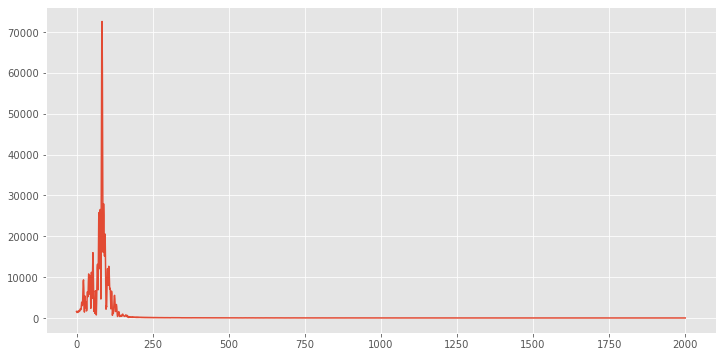

In [33]:
plt.plot(data_raw_window['fft_ppg'][i, :])

In [34]:
data_raw_window.keys()

dict_keys(['ppg', 'accx', 'accy', 'accz', 'ppg_filtered', 'accx_filtered', 'accy_filtered', 'accz_filtered', 'acc_abs_filtered', 'freqs', 'fft_ppg', 'fft_accx', 'fft_accy', 'fft_accz', 'fft_acc_abs', 'fft_acc_sum'])

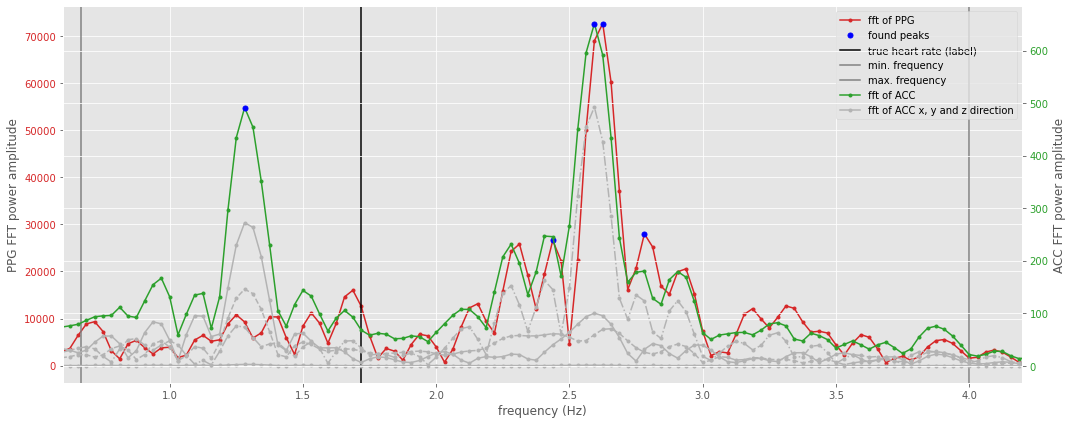

In [42]:
fig = plot_window_prediction(
    freqs=data_raw_window['freqs'][i, :],
    ppg_fft=data_raw_window['fft_ppg'][i, :],
    ppg_peaks=ppg_xpeak,
    ppg_label=labels[i],
    acc_fft=data_raw_window['fft_acc_sum'][i, :],
    accx_fft=data_raw_window['fft_accx'][i, :],
    accy_fft=data_raw_window['fft_accy'][i, :],
    accz_fft=data_raw_window['fft_accz'][i, :],
    acc_peaks=acc_xpeak,
    min_freq=min_freq,
    max_freq=max_freq
)

In [11]:
for key, value in data_raw_window.items():
    print(key, value.shape)

ppg (1726, 1000)
accx (1726, 1000)
accy (1726, 1000)
accz (1726, 1000)
ppg_filtered (1726, 1000)
accx_filtered (1726, 1000)
accy_filtered (1726, 1000)
accz_filtered (1726, 1000)
acc_abs_filtered (1726, 1000)
freqs (1726, 2001)
fft_ppg (1726, 2001)
fft_accx (1726, 2001)
fft_accy (1726, 2001)
fft_accz (1726, 2001)
fft_acc_abs (1726, 2001)
fft_acc_sum (1726, 2001)


### Information about dataset:

In [6]:
data_fls, ref_fls = LoadTroikaDataset()

for i, data_fl in enumerate(data_fls):
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    ppg_ref = load_labels(ref_fls[i])
    print(f"signal length of {data_fl.split('/')[-1]} = {len(ppg)/FS} sec ({len(ppg)})")
    print(f'ppg signal min: {ppg.min()}')
    print(f'ppg signal max: {ppg.max()}')
    ts_upper = np.arange(0, len(ppg_ref), 1) * WINDOW_SHIFT_SEC + WINDOW_LENGTH_SEC
    print(f"reference signal length (largest upper interval limit): {ts_upper[-1]} sec ({ts_upper[-1]*FS})")
    print(f'reference signal min: {ppg_ref.min():.4} BPM ({ppg_ref.min()/60:.4} Hz)')
    print(f'reference signal max: {ppg_ref.max():.4} BPM ({ppg_ref.max()/60:.4} Hz)')
    print()
    assert len(ppg)==len(accx)==len(accy)==len(accz), 'PPG and acceleration signal length do not match'

signal length of DATA_01_TYPE01.mat = 303.496 sec (37937)
ppg signal min: -1023.5
ppg signal max: 914.0
reference signal length (largest upper interval limit): 302 sec (37750)
reference signal min: 69.59 BPM (1.16 Hz)
reference signal max: 165.6 BPM (2.76 Hz)

signal length of DATA_02_TYPE02.mat = 302.8 sec (37850)
ppg signal min: -218.5
ppg signal max: 164.0
reference signal length (largest upper interval limit): 302 sec (37750)
reference signal min: 69.52 BPM (1.159 Hz)
reference signal max: 148.6 BPM (2.477 Hz)

signal length of DATA_03_TYPE02.mat = 287.912 sec (35989)
ppg signal min: -480.0
ppg signal max: 303.5
reference signal length (largest upper interval limit): 286 sec (35750)
reference signal min: 83.71 BPM (1.395 Hz)
reference signal max: 160.4 BPM (2.674 Hz)

signal length of DATA_04_TYPE01.mat = 220.608 sec (27576)
ppg signal min: -281.5
ppg signal max: 151.5
reference signal length (largest upper interval limit): 220 sec (27500)
reference signal min: 66.3 BPM (1.105 Hz)


### Import and visualize one example data

In [7]:
i_sample = 7
# import example data
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[i_sample])
# acc = np.sqrt(accx**2 + accy**2 + accz**2)
# acc = np.sqrt(accx**2 + (accy-np.mean(accy))**2 + accz**2)

# apply band pass filter to each signal:
ppg_filtered = bandpassFilter(signal=ppg, pass_band=(min_freq, max_freq), fs=FS)
accx_filtered = bandpassFilter(signal=accx, pass_band=(min_freq, max_freq), fs=FS)
accy_filtered = bandpassFilter(signal=accy, pass_band=(min_freq, max_freq), fs=FS)
accz_filtered = bandpassFilter(signal=accz, pass_band=(min_freq, max_freq), fs=FS)
acc_filtered = np.sqrt(accx_filtered**2 + accy_filtered**2 + accz_filtered**2)
acc_filtered1 = np.sqrt(accx_filtered**2 + (accy_filtered - np.mean(accy_filtered))**2 + accz_filtered**2)

# get labels
ppg_ref = load_labels(ref_fls[i_sample])
ts_center = np.arange(0, len(ppg_ref), 1) * WINDOW_SHIFT_SEC + WINDOW_LENGTH_SEC / 2
ts_lower = np.arange(0, len(ppg_ref), 1) * WINDOW_SHIFT_SEC
ts_upper = np.arange(0, len(ppg_ref), 1) * WINDOW_SHIFT_SEC + WINDOW_LENGTH_SEC

In [8]:
# FFT each signal 
freqs, ppg_fft = rfft_window(signal=ppg_filtered, fs=FS,
                             window_length=window_length, window_shift=window_shift,
                             fft_pad_factor=4)
freqs, accx_fft = rfft_window(signal=accx_filtered, fs=FS,
                              window_length=window_length, window_shift=window_shift,
                              fft_pad_factor=4)
freqs, accy_fft = rfft_window(signal=accy_filtered, fs=FS,
                              window_length=window_length, window_shift=window_shift,
                              fft_pad_factor=4)
freqs, accz_fft = rfft_window(signal=accz_filtered, fs=FS,
                              window_length=window_length, window_shift=window_shift,
                              fft_pad_factor=4)
freqs, acc_fft = rfft_window(signal=acc_filtered, fs=FS,
                             window_length=window_length, window_shift=window_shift,
                             fft_pad_factor=4)
freqs, acc_fft1 = rfft_window(signal=acc_filtered1, fs=FS,
                             window_length=window_length, window_shift=window_shift,
                             fft_pad_factor=4)
acc_fft2 = (accx_fft + accy_fft + accz_fft)

In [82]:
i = 30
## The prominence of a peak measures how much a peak stands out from the surrounding
## baseline of the signal and is defined as the vertical distance between the peak
## and its lowest contour line.
## threshold of peaks: the vertical distance to its neighboring samples.
## wlen: A window length in samples that optionally limits the evaluated area for
## each peak to a subset of x. The peak is always placed in the middle of the window 
## therefore the given length is rounded up to the next odd integer
ppg_xpeak, dict_ppg_ypeak = sp.signal.find_peaks(
    x=ppg_fft[:, i], height=ppg_fft[:, i].max()*0.1, distance=2,
    prominence=ppg_fft[:, i].max()*0.15, threshold=None, wlen=5
)
acc_xpeak, dict_acc_ypeak = sp.signal.find_peaks(
    x=acc_fft[:, i], height=acc_fft[:, i].max()*0.3, distance=3,
    prominence=acc_fft[:, i].max()*0.2, threshold=None, wlen=5
)
print(f'PPG peaks: {freqs[ppg_xpeak]*60} BPM')
print(f'ACC peaks: {freqs[acc_xpeak]*60} BPM')
print(f'label: {ppg_ref[i]} BPM')


PPG peaks: [118.125 144.375] BPM
ACC peaks: [] BPM
label: 117.31843575418995 BPM


(0.0, 1200.0)

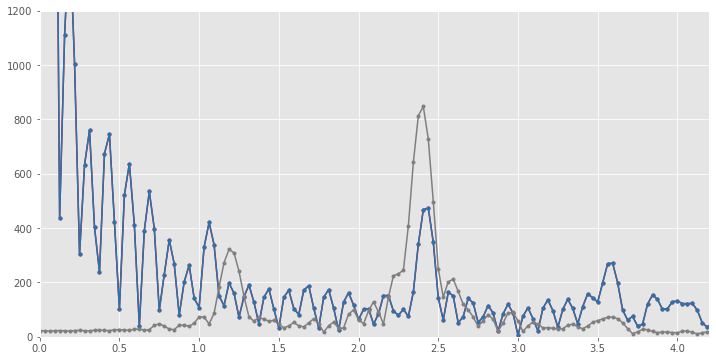

In [83]:
fig, ax = plt.subplots()
ax.plot(freqs, acc_fft[:, i]*10, '.-', color='r', label='fft of ACC (mag from time signal)')

color = 'tab:blue'
ax.plot(freqs, acc_fft1[:, i]*10, '.-', color=color, label='fft of ACC (adjusted mag from time signal)')

color = 'tab:gray'
ax.plot(freqs, acc_fft2[:, i], '.-', color=color, label='fft of ACC (summed frequencies)')
ax.set_xlim(0., max_freq*1.05)
ax.set_ylim(0,1200)

In [96]:
min_freq

0.6666666666666666

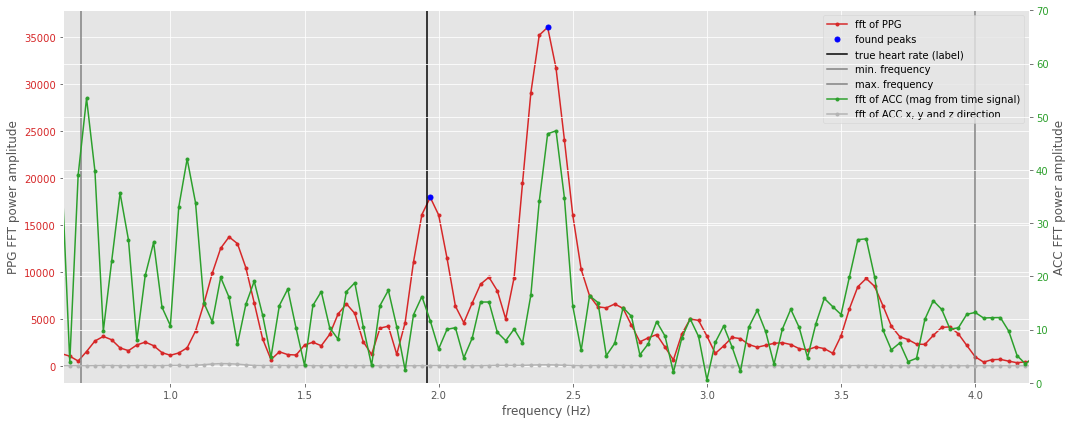

In [84]:
fig = plot_window_prediction(freqs=freqs, ppg_fft=ppg_fft[:, i], ppg_peaks=ppg_xpeak, ppg_label=ppg_ref[i],
                             acc_fft=acc_fft[:, i], acc_fft1=acc_fft1[:, i], acc_fft2=acc_fft2[:, i],
                             accx_fft=accx_fft[:, i], accy_fft=accy_fft[:, i],
                             accz_fft=accz_fft[:, i], acc_peaks=acc_xpeak, min_freq=min_freq, max_freq=max_freq)

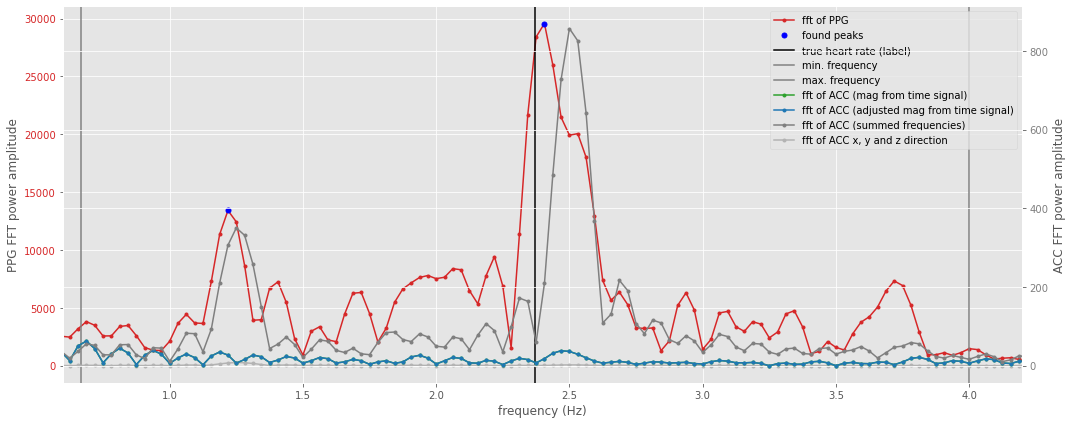

In [48]:
fig = plot_window_prediction (freqs=freqs, ppg_fft=ppg_fft[:, i], ppg_peaks=ppg_xpeak, ppg_label=ppg_ref[i],
                              acc_fft=acc_fft[:, i], acc_fft1=acc_fft1[:, i], acc_fft2=acc_fft2[:, i],
                              accx_fft=accx_fft[:, i], accy_fft=accy_fft[:, i],
                              accz_fft=accz_fft[:, i], acc_peaks=acc_xpeak, min_freq=min_freq, max_freq=max_freq)

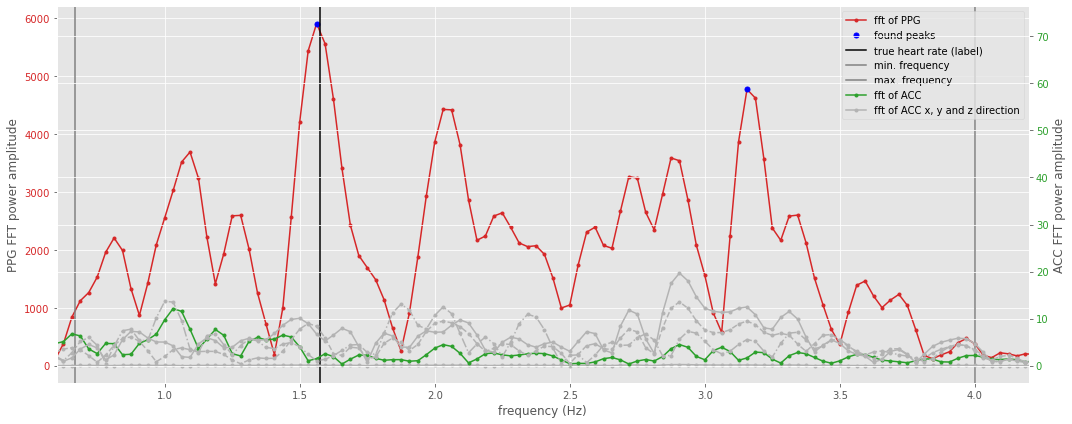

In [13]:
fig = plot_window_prediction (freqs=freqs, ppg_fft=ppg_fft[:, i], ppg_peaks=ppg_xpeak, ppg_label=ppg_ref[i],
                              acc_fft=acc_fft[:, i], accx_fft=accx_fft[:, i], accy_fft=accy_fft[:, i],
                              accz_fft=accz_fft[:, i], acc_peaks=acc_xpeak, min_freq=min_freq, max_freq=max_freq)

# Plots

Text(0.5, 1.0, 'ppg signal (time domain) window 10')

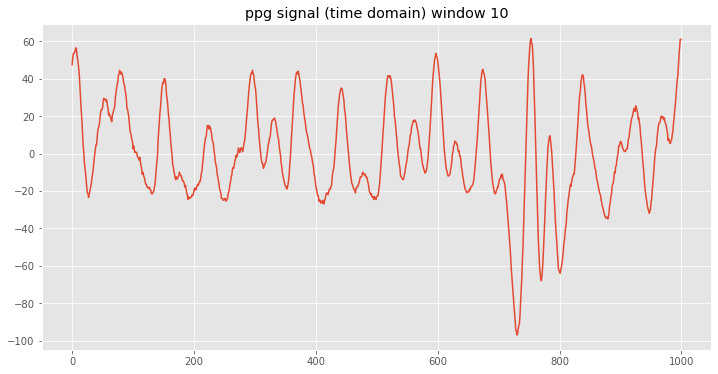

In [30]:
i=10
plt.plot(ppg[i:i+window_length])
plt.title(f'ppg signal (time domain) window {i}')

Text(0.5, 1.0, 'bandpass filtered ppg signal (time domain) window 10')

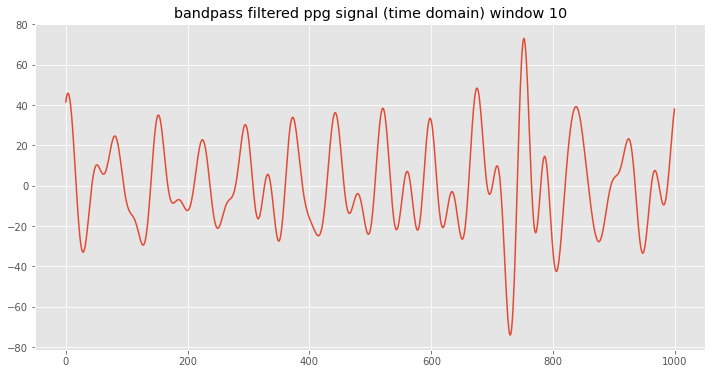

In [32]:
plt.plot(bandpassFilter(signal=ppg, pass_band=(min_freq, max_freq), fs=FS)[i:i+window_length])
plt.title(f'bandpass filtered ppg signal (time domain) window {i}')

Text(0.5, 1.0, 'bandpass filtered ppg signal (time domain) window 10 window only band-passed')

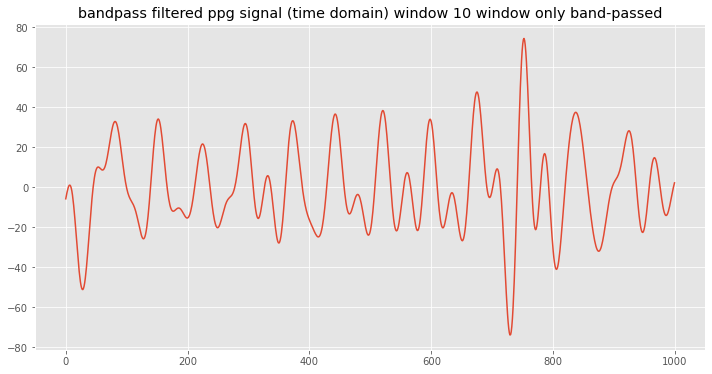

In [34]:
plt.plot(bandpassFilter(signal=ppg[i:i+window_length], pass_band=(min_freq, max_freq), fs=FS))
plt.title(f'bandpass filtered ppg signal (time domain) window {i} window only band-passed')

Text(0.5, 1.0, 'ppg signal (frequency domain) window 10 without bandpass')

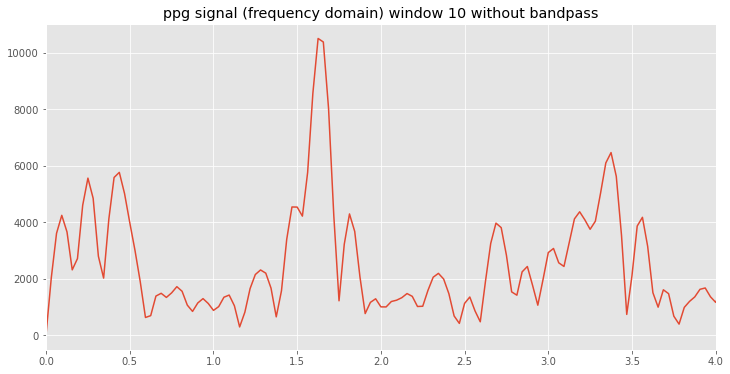

In [43]:
freqs = np.fft.rfftfreq(len(ppg[i:i+window_length])*4, 1/FS)
fft = np.abs(np.fft.rfft(ppg[i:i+window_length], n=len(ppg[i:i+window_length])*4, axis=-1))
plt.plot(freqs, fft)
plt.xlim(0, 4)
plt.title(f'ppg signal (frequency domain) window {i} without bandpass')

Text(0.5, 1.0, 'ppg signal (frequency domain) window 10')

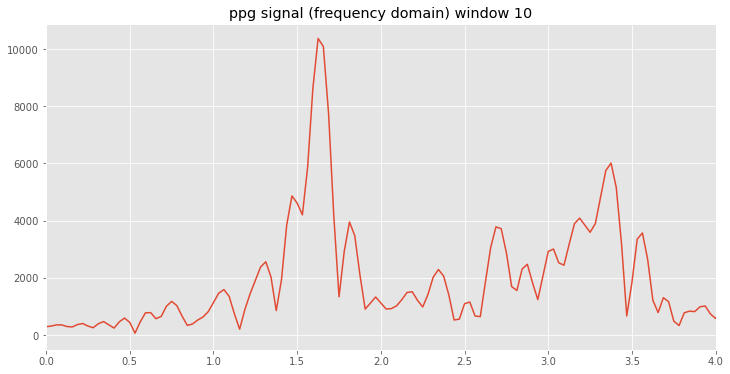

In [41]:
signal = bandpassFilter(signal=ppg, pass_band=(min_freq, max_freq), fs=FS)[i:i+window_length]
freqs = np.fft.rfftfreq(len(signal)*4, 1/FS)
fft = np.abs(np.fft.rfft(signal, n=len(signal)*4, axis=-1))
plt.plot(freqs, fft)
plt.xlim(0, 4)
plt.title(f'ppg signal (frequency domain) window {i}')

Text(0.5, 1.0, 'ppg signal (frequency domain) window 10 window only bandpassed')

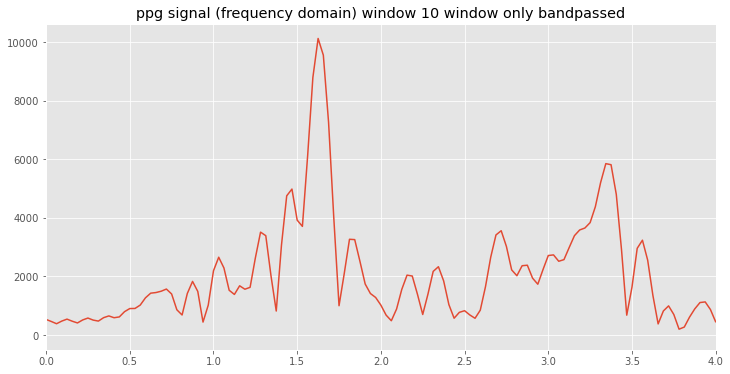

In [42]:
signal = bandpassFilter(signal=ppg[i:i+window_length], pass_band=(min_freq, max_freq), fs=FS)
freqs = np.fft.rfftfreq(len(signal)*4, 1/FS)
fft = np.abs(np.fft.rfft(signal, n=len(signal)*4, axis=-1))
plt.plot(freqs, fft)
plt.xlim(0, 4)
plt.title(f'ppg signal (frequency domain) window {i} window only bandpassed')

In [ ]:
def rfft_window(signal, fs, window_length, window_shift, fft_pad_factor=4):
    """
    Performs a RFFT of a signal in smaller sequences given by window_length and 
    window_shift parameters.
    :param signal: signal that is Fourier transformed
    :param fs: sample frequency
    :param window_length: length of the window/filter (in sample units)
    :param window_shift: shift of window for each step/ stride (in sample units)
    :param fft_pad_factor: factor for zero padding of FFT for higher resolution
        in frequency space
    :return: tuple with frequencies and RFFT
    """
    freqs = np.fft.rfftfreq(window_length*fft_pad_factor, 1/fs)
    fft = []
    for i in range(0, len(signal), window_shift):
        if signal[i:i+window_length].shape[0]==window_length:
            time_series = signal[i:i+window_length]
            # we use n>len(time_series) -> we pad the input signal with
            # zeros so that we get a higher resolution in frequency space
            fft += [np.abs(np.fft.rfft(time_series, n=window_length*fft_pad_factor,
                                       axis=-1))]
    fft = np.stack(fft, axis=1)
    return freqs, fft

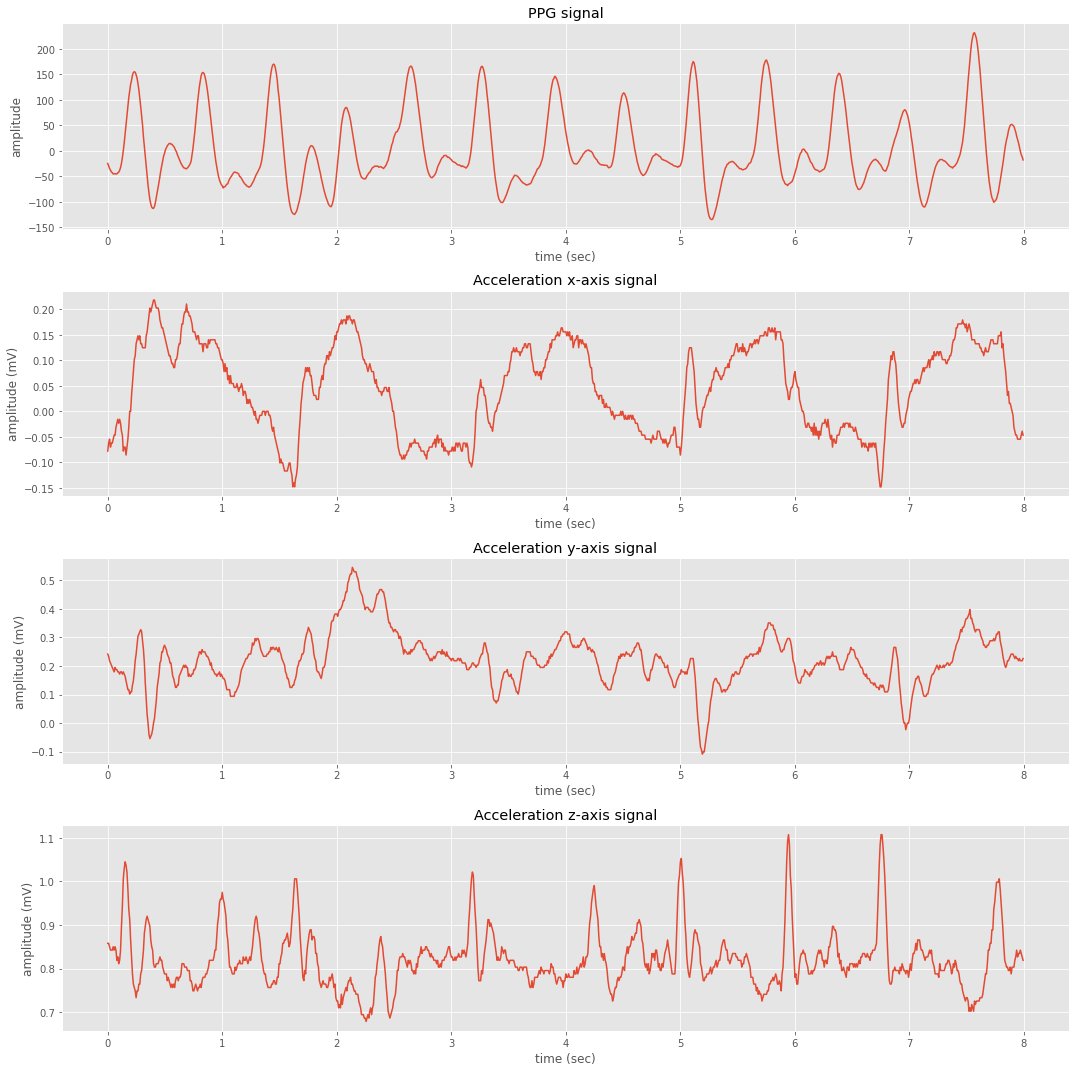

In [100]:
i=100
fig = plot_raw_signals(ppg=ppg[i:i+window_length], accx=accx[i:i+window_length],
                       accy=accy[i:i+window_length], accz=accz[i:i+window_length])

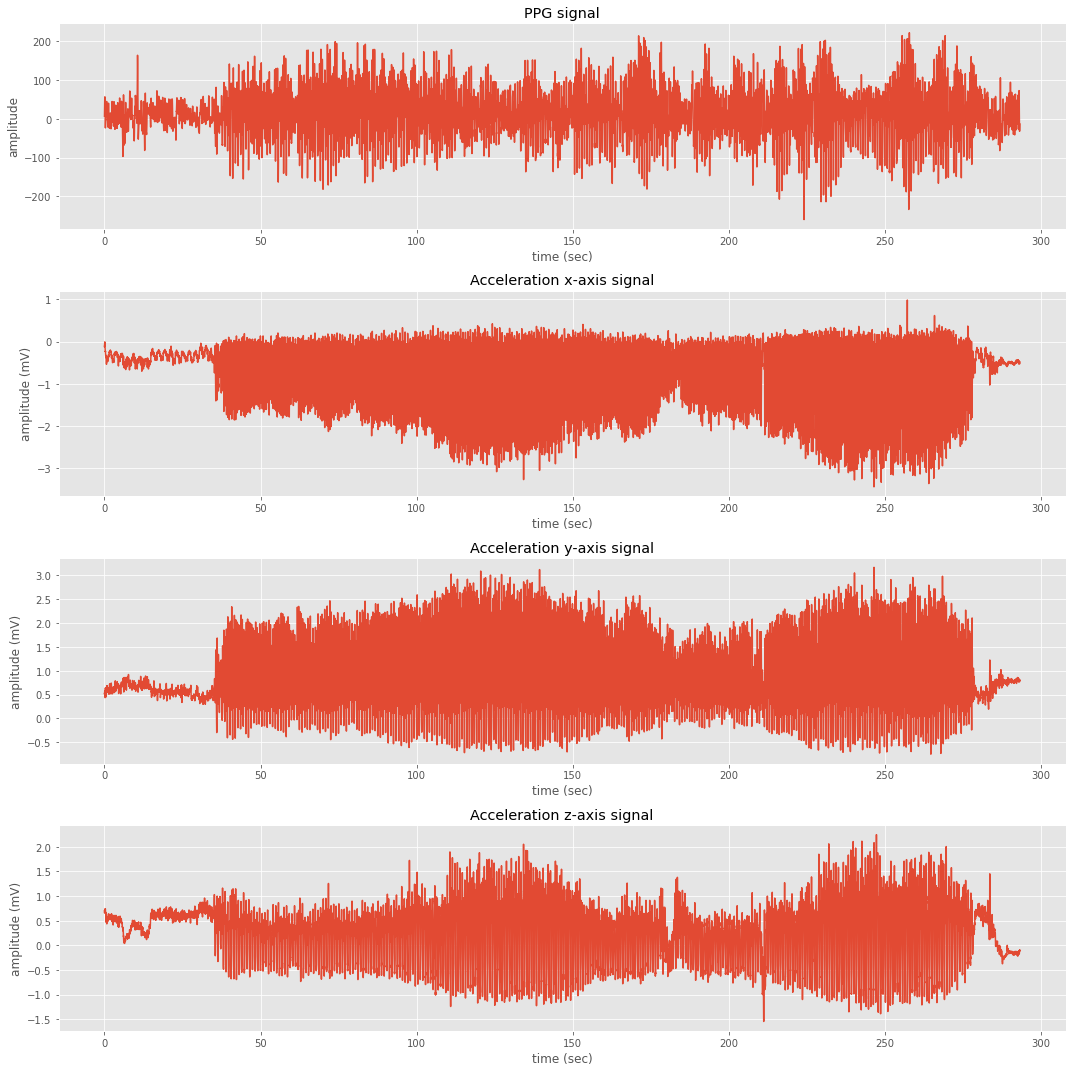

In [11]:
fig = plot_raw_signals(ppg=ppg, accx=accx, accy=accy, accz=accz)

Filtered data:


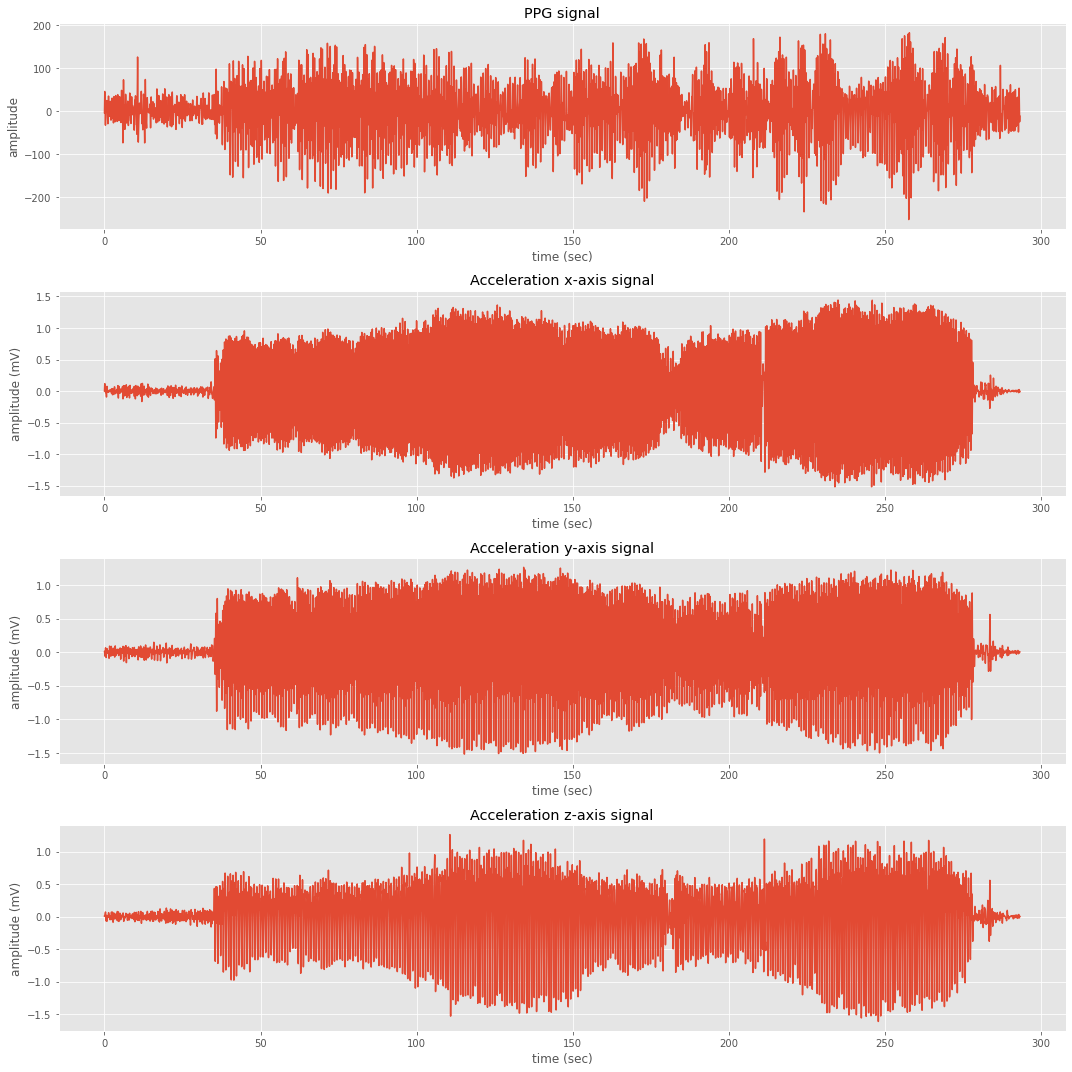

In [12]:
print('Filtered data:')
fig = plot_raw_signals(ppg=ppg_filtered, accx=accx_filtered, accy=accy_filtered, accz=accz_filtered)

Text(0.5, 1.0, 'Reference PPG signal (labels)')

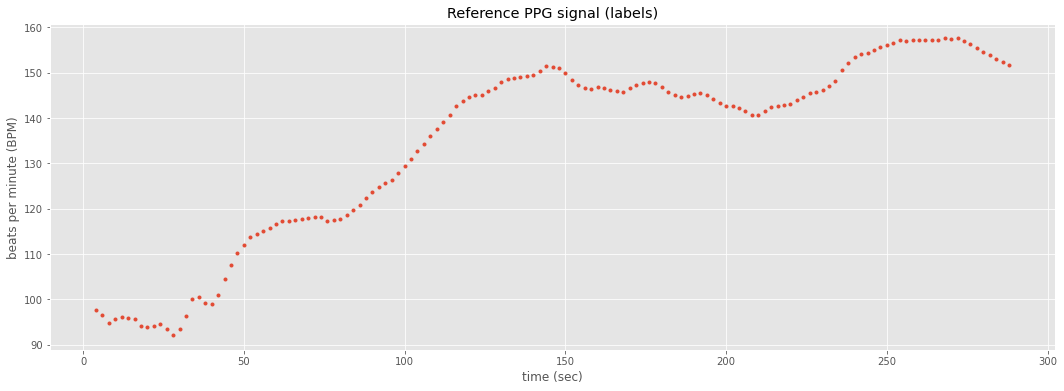

In [13]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(ts_center, ppg_ref, '.')
ax.set_xlabel('time (sec)')
ax.set_ylabel('beats per minute (BPM)')
ax.set_title('Reference PPG signal (labels)')

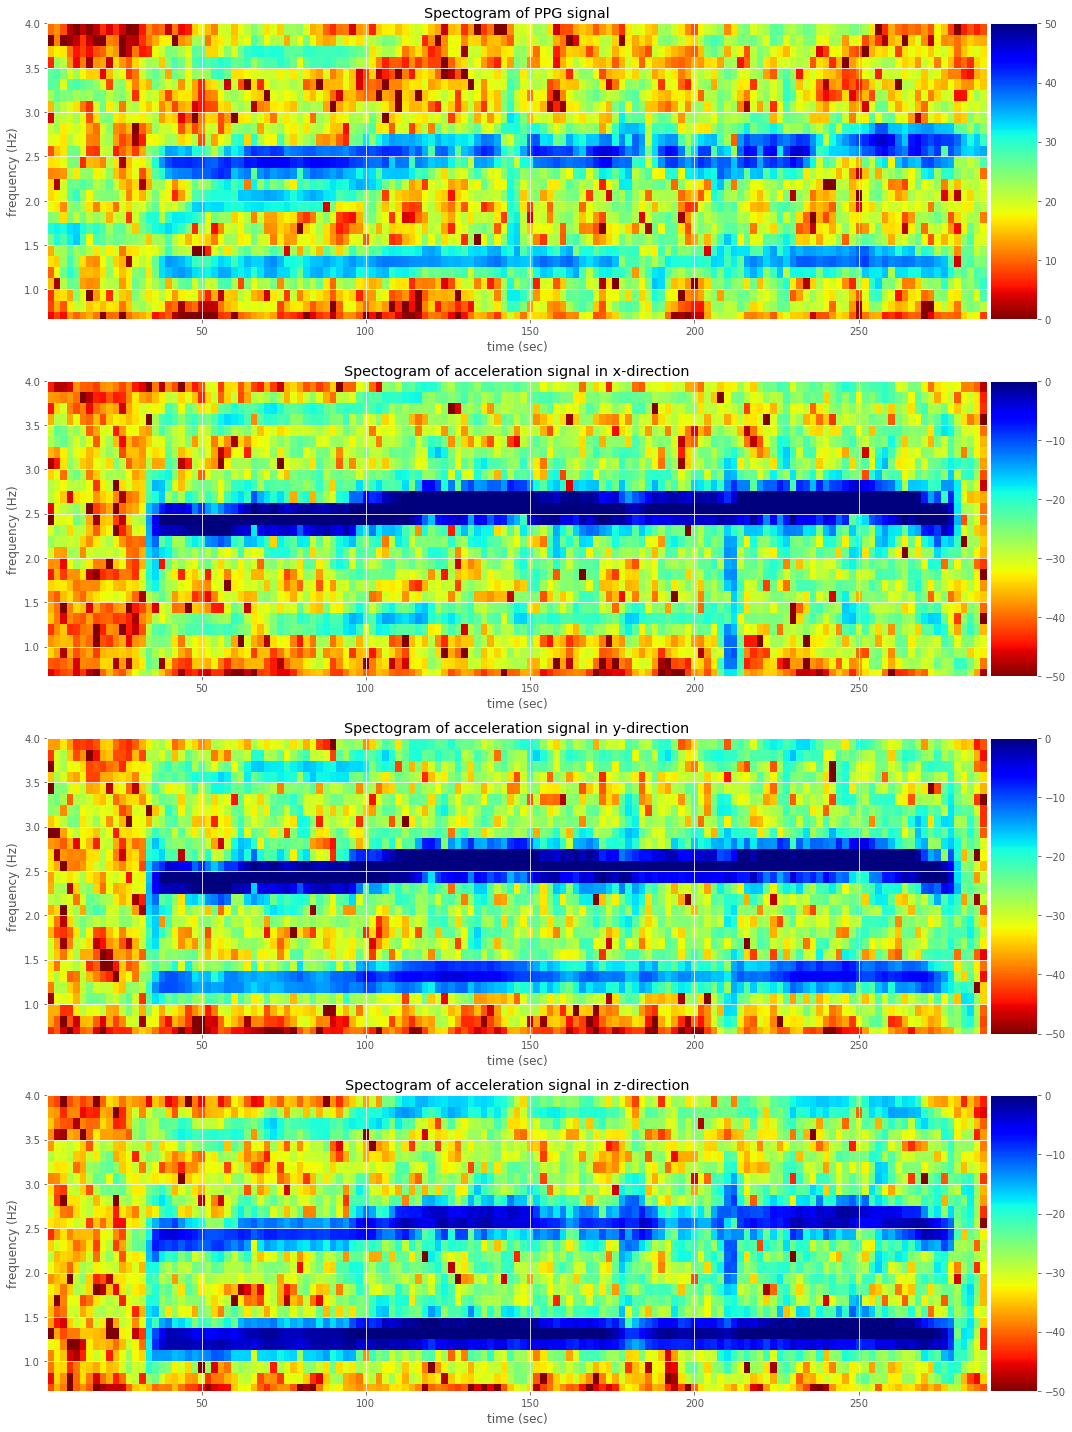

In [14]:
fig = plot_spectogram(ppg=ppg_filtered, accx=accx_filtered, accy=accy_filtered, accz=accz_filtered, fs=FS,
                      window_length=window_length, window_shift=window_shift, min_freq=min_freq, max_freq=max_freq)

Text(0.5, 1.0, 'Reference PPG signal (labels)')

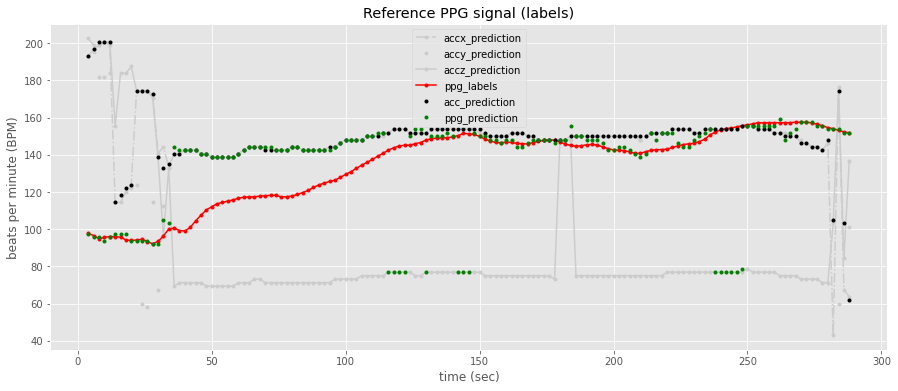

In [25]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(ts_center, freqs[np.argmax(accx_fft, axis=0)] * 60, '.-.', color='0.8', label='accx_prediction')
ax.plot(ts_center, freqs[np.argmax(accy_fft, axis=0)] * 60, '.', color='0.8', label='accy_prediction')
ax.plot(ts_center, freqs[np.argmax(accz_fft, axis=0)] * 60, '.-', color='0.8', label='accz_prediction')
ax.plot(ts_center, ppg_ref, '.-', color='r', label='ppg_labels')
ax.plot(ts_center, freqs[np.argmax(acc_fft, axis=0)] * 60, '.', color='k', label='acc_prediction')
ax.plot(ts_center, freqs[np.argmax(ppg_fft, axis=0)] * 60, '.', color='g', label='ppg_prediction')
ax.legend()
ax.set_xlabel('time (sec)')
ax.set_ylabel('beats per minute (BPM)')
ax.set_title('Reference PPG signal (labels)')

In [16]:
# def RunPulseRateAlgorithm(data_fl, ref_fl):
#     # Sample Frequency
#     fs = 125
#     # Window to calculate reference pulse rate
#     win_len = 8
#     # Difference between time windows
#     win_shift = 2    
       
#     reg, scores = load_regressor()
#     targets, features, sigs, subs = load_data(data_fl, ref_fl)
#     error, confidence = [], []
#     for i,feature in enumerate(features):
#         est = reg.predict(np.reshape(feature, (1, -1)))[0]
        
#         # Calculate confidence
#         ppg, accx, accy, accz = sigs[i]
        
#         ppg = bandpass_filter(ppg)        
#         accx = bandpass_filter(accx)
#         accy = bandpass_filter(accy)
#         accz = bandpass_filter(accz)        
        
#         n = len(ppg) * 3
#         freqs = np.fft.rfftfreq(n, 1/fs)
#         fft = np.abs(np.fft.rfft(ppg,n))
#         fft[freqs <= 40/60.0] = 0.0
#         fft[freqs >= 240/60.0] = 0.0
    
#         # Max magnitude frequency
#         est_fs = est / 55.0
#         fs_win = 30  / 60.0
#         fs_win_e = (freqs >= est_fs - fs_win) & (freqs <= est_fs +fs_win)
#         conf = np.sum(fft[fs_win_e])/np.sum(fft)
        
#         error.append(np.abs((est-targets[i])))
#         confidence.append(conf)
#     return np.array(error), np.array(confidence)

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 